In [ ]:
! pip install opendatasets

In [ ]:
#==========================================
# import libraries
#==========================================

import warnings
warnings.filterwarnings('ignore')

import opendatasets as od
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [ ]:
#=============================================
# Step-2: Download Dataset
#=============================================


od.download('https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chanchalsaha7
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images


100%|██████████| 3.10G/3.10G [00:35<00:00, 94.6MB/s]


In [ ]:
#===========================================
# Create DataFrame
# ==========================================

base_dir='/content/breast-histopathology-images'

pattern=os.path.join(base_dir,'**','*.png')
filepaths=glob.glob(pattern,recursive=True)

label=[ os.path.basename(os.path.dirname(fp)) for fp in filepaths ]

df=pd.DataFrame({
    'label':label,
    'path':filepaths
})

train_df,val_test_df=train_test_split(df,test_size=0.2,random_state=42,stratify=df['label'])
val_df,test_df=train_test_split(val_test_df,test_size=0.5,random_state=42,stratify=val_test_df['label'])

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(444038, 2)
(55505, 2)
(55505, 2)


In [ ]:
#-====================================================
# Data Augmentation + Normalization + Data Generator
##====================================================
BATCH_SIZE=16
IMG_SIZE=(50,50)
EPOCHS=5
SEED=42

Datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True
)

val_test_datagen=ImageDataGenerator(
    rescale=1./255
)

# Train Generator

train_gen=Datagen.flow_from_dataframe(
    train_df,
    target_size=IMG_SIZE,
    x_col='path',
    y_col='label',
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    class_mode='binary'
)

# Val Generator

val_gen=val_test_datagen.flow_from_dataframe(
    val_df,
    target_size=IMG_SIZE,
    x_col='path',
    y_col='label',
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode='binary'
)

# Test Generator

test_gen=val_test_datagen.flow_from_dataframe(
    test_df,
    target_size=IMG_SIZE,
    x_col='path',
    y_col='label',
    shuffle=False,
    batch_size=BATCH_SIZE,
    seed=SEED,
    class_mode='binary'
)

Found 444038 validated image filenames belonging to 2 classes.
Found 55505 validated image filenames belonging to 2 classes.
Found 55505 validated image filenames belonging to 2 classes.


In [ ]:
#========================================
# Transfer Learning Model (ResNet50)
#========================================

base_model= VGG16(weights='imagenet',include_top=False,input_shape=IMG_SIZE+(3,))
base_model.trainable=False

model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1,activation='sigmoid')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(
    optimizer=Adam(learning_rate= 1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
cb=[
    EarlyStopping(patience=3,restore_best_weights=True),
    ModelCheckpoint('best_model_vgg16.h5',save_best_only=True)
]

In [ ]:
#-------------------------------
# Train Frozen Model(Baseline)
#-------------------------------

history=model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=cb
)

Epoch 1/5
27752/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7712 - loss: 0.5001

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 970s 35ms/step - accuracy: 0.7712 - loss: 0.5001 - val_accuracy: 0.8160 - val_loss: 0.4377
Epoch 2/5
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8007 - loss: 0.4551

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 824s 30ms/step - accuracy: 0.8007 - loss: 0.4551 - val_accuracy: 0.8191 - val_loss: 0.4325
Epoch 3/5
27751/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8020 - loss: 0.4523

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 734s 26ms/step - accuracy: 0.8020 - loss: 0.4523 - val_accuracy: 0.8188 - val_loss: 0.4302
Epoch 4/5
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8056 - loss: 0.4478

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 742s 27ms/step - accuracy: 0.8056 - loss: 0.4478 - val_accuracy: 0.8192 - val_loss: 0.4281
Epoch 5/5
27752/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8051 - loss: 0.4472

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 745s 27ms/step - accuracy: 0.8051 - loss: 0.4472 - val_accuracy: 0.8200 - val_loss: 0.4277


3470/3470 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - accuracy: 0.8215 - loss: 0.4231
--------------------------------Before fine tuning--------------------------
Test Accuracy: 81.86%
3470/3470 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step
3470/3470 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step
ROC-AUC: 0.8443230406073717


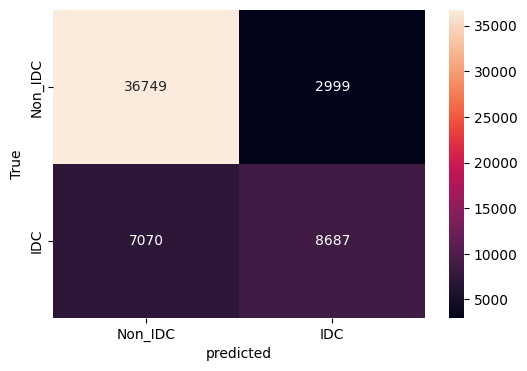

              precision    recall  f1-score   support

     Non_IDC       0.84      0.92      0.88     39748
         IDC       0.74      0.55      0.63     15757

    accuracy                           0.82     55505
   macro avg       0.79      0.74      0.76     55505
weighted avg       0.81      0.82      0.81     55505



In [ ]:
#----------------------------------
# Evaluation
#----------------------------------
loss,acc =model.evaluate(test_gen)

print('--------------------------------Before fine tuning--------------------------')
print(f'Test Accuracy: {acc*100:.2f}%')

# Confusion matrix
y_true=test_gen.classes
y_pred=(model.predict(test_gen)>0.5).astype('int32').flatten()

# ROC_AUC_SCORE
from sklearn.metrics import roc_auc_score

y_prob = model.predict(test_gen).ravel()
print("ROC-AUC:", roc_auc_score(y_true, y_prob))

cm=confusion_matrix(y_true,y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=['Non_IDC','IDC'],yticklabels=['Non_IDC','IDC'])
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()


 # classification report
print(classification_report(y_true,y_pred,target_names=['Non_IDC','IDC']))



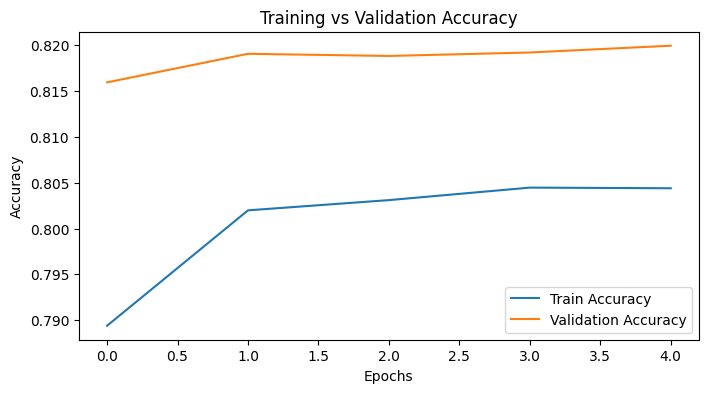

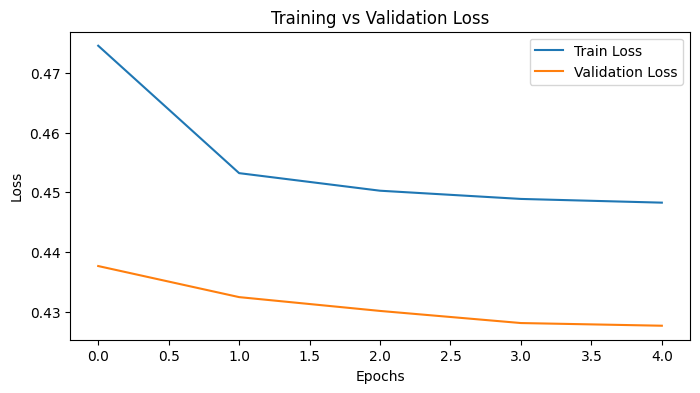

In [ ]:
# Training & Validation Accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Training & Validation Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
#--------------------------------
# Base model Unfreeze
#---------------------------------

base_model.trainable=True

# fine-tune only last 50 layers

for layer in base_model.layers[:-50]:
  layer.trainable=False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)




In [ ]:
cb=[
    EarlyStopping(patience=5,restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5,patience=3),
    ModelCheckpoint('fine_tuned_model.h5',save_best_only=True)
]

In [15]:
h2=model.fit(
    train_gen,
    validation_data=val_gen,
    callbacks=cb,
    epochs=7
)

Epoch 1/7
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8598 - loss: 0.3308

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 1500s 54ms/step - accuracy: 0.8598 - loss: 0.3308 - val_accuracy: 0.8811 - val_loss: 0.2805 - learning_rate: 1.0000e-05
Epoch 2/7
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8854 - loss: 0.2725

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 1488s 54ms/step - accuracy: 0.8854 - loss: 0.2725 - val_accuracy: 0.8872 - val_loss: 0.2635 - learning_rate: 1.0000e-05
Epoch 3/7
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8936 - loss: 0.2546

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 1483s 53ms/step - accuracy: 0.8936 - loss: 0.2546 - val_accuracy: 0.8956 - val_loss: 0.2515 - learning_rate: 1.0000e-05
Epoch 4/7
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8999 - loss: 0.2415

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 1489s 54ms/step - accuracy: 0.8999 - loss: 0.2415 - val_accuracy: 0.9031 - val_loss: 0.2362 - learning_rate: 1.0000e-05
Epoch 5/7
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 1477s 53ms/step - accuracy: 0.9010 - loss: 0.2377 - val_accuracy: 0.8980 - val_loss: 0.2506 - learning_rate: 1.0000e-05
Epoch 6/7
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9036 - loss: 0.2337

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 1485s 53ms/step - accuracy: 0.9036 - loss: 0.2337 - val_accuracy: 0.9042 - val_loss: 0.2307 - learning_rate: 1.0000e-05
Epoch 7/7
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 1482s 53ms/step - accuracy: 0.9078 - loss: 0.2238 - val_accuracy: 0.9011 - val_loss: 0.2855 - learning_rate: 1.0000e-05


3470/3470 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - accuracy: 0.9053 - loss: 0.2250
--------------------------------After fine tuning--------------------------
 Test Accuracy: 90.41%
3470/3470 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step


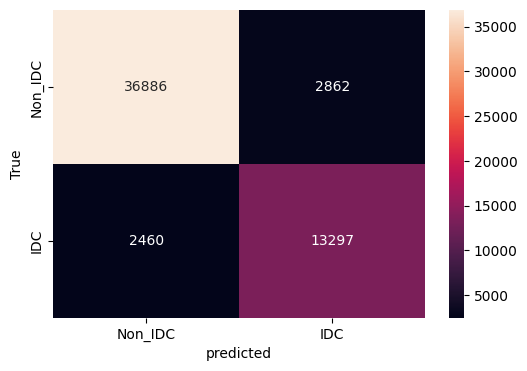

              precision    recall  f1-score   support

     Non_IDC       0.94      0.93      0.93     39748
         IDC       0.82      0.84      0.83     15757

    accuracy                           0.90     55505
   macro avg       0.88      0.89      0.88     55505
weighted avg       0.90      0.90      0.90     55505



In [16]:
# Evaluation
loss,acc =model.evaluate(test_gen)
print('--------------------------------After fine tuning--------------------------')
print(f' Test Accuracy: {acc*100:.2f}%')

# Confusion matrix
y_true=test_gen.classes
y_pred=(model.predict(test_gen)>0.5).astype('int32').flatten()

cm=confusion_matrix(y_true,y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=['Non_IDC','IDC'],yticklabels=['Non_IDC','IDC'])
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()


 # classification report
print(classification_report(y_true,y_pred,target_names=['Non_IDC','IDC']))




In [ ]:


y_prob = model.predict(test_gen).ravel()
print("ROC-AUC:", roc_auc_score(y_true, y_prob))

3470/3470 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step
ROC-AUC: 0.801355136809766


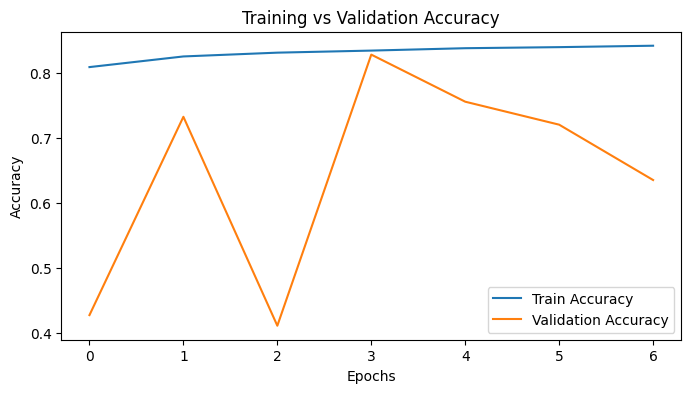

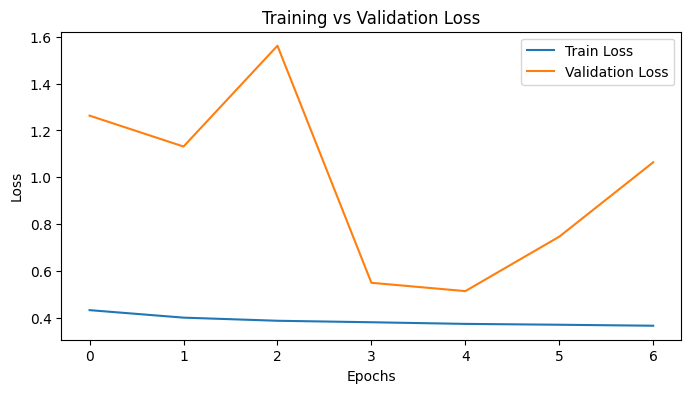

In [ ]:
# Training & Validation Accuracy
plt.figure(figsize=(8,4))
plt.plot(h2.history['accuracy'], label='Train Accuracy')
plt.plot(h2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Training & Validation Loss
plt.figure(figsize=(8,4))
plt.plot(h2.history['loss'], label='Train Loss')
plt.plot(h2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()